In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)
torch.manual_seed(42)


In [4]:
N = 5000
G_true = np.random.uniform(0.001, 10.0, N)  # true conductance
v = np.random.uniform(0.1, 10, N)           # avoid divide-by-zero
v = G_true * i                              # i = G * v


In [6]:
noise = np.random.normal(0, 0.01, size=N)
i_noisy = i + noise


In [7]:
X = np.stack((v, i_noisy), axis=1)
y = G_true  # target


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [9]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [10]:
class GRegressor(nn.Module):
    def __init__(self):
        super(GRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # output is a single float: G
        )
    def forward(self, x):
        return self.net(x)


In [11]:
model = GRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


Epoch 10/100, Loss: 31.631905
Epoch 20/100, Loss: 29.050407
Epoch 30/100, Loss: 26.221575
Epoch 40/100, Loss: 22.771767
Epoch 50/100, Loss: 18.953091
Epoch 60/100, Loss: 15.133098
Epoch 70/100, Loss: 11.822553
Epoch 80/100, Loss: 9.508480
Epoch 90/100, Loss: 8.290220
Epoch 100/100, Loss: 7.729735


In [13]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).squeeze().numpy()
    y_true = y_test_t.squeeze().numpy()


In [14]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


In [15]:
print("\n📊 Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")




📊 Evaluation Metrics:
MAE: 2.4795
MSE: 8.4017
R² Score: 0.0400


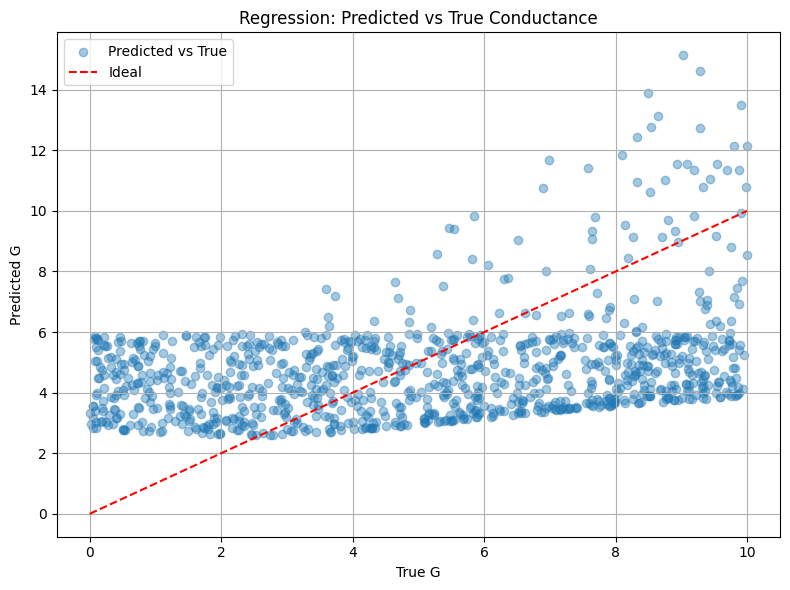

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4, label='Predicted vs True')
plt.plot([0, 10], [0, 10], 'r--', label='Ideal')
plt.xlabel("True G")
plt.ylabel("Predicted G")
plt.title("Regression: Predicted vs True Conductance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
